In [564]:
%pip install --upgrade pip
# %pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 #comment if not using gpu
%pip -q install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [565]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils.rnn import pack_sequence, pad_sequence
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import json
import matplotlib.pyplot as plt
from pathlib import Path


In [566]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "model.pth"

In [567]:
batch_size = 1
industry_size = 32
product_name_size = 20
product_category_size = 26

In [568]:
class LSTMComponent(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(LSTMComponent, self).__init__()
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input):
        packed_input = pack_sequence(input, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_input)
        return self.fc(hidden.squeeze(0))

class RecommenderModel(nn.Module):
    def __init__(self, industry_size, product_name_size, product_category_size, hidden_dim, padding_value=-1):
        super(RecommenderModel, self).__init__()

        self.product_name_size = product_name_size
        self.padding_value = padding_value

        self.industry_embedding = nn.Embedding(num_embeddings=industry_size+1, embedding_dim=hidden_dim, padding_idx=industry_size)
        self.product_name_embedding = nn.Embedding(num_embeddings=product_name_size+1, embedding_dim=hidden_dim, padding_idx=product_name_size)
        self.product_category_embedding = nn.Embedding(num_embeddings=product_category_size+1, embedding_dim=hidden_dim, padding_idx=product_category_size)
        self.product_is_implemented_embedding = nn.Embedding(num_embeddings=3, embedding_dim=hidden_dim, padding_idx=2)

        self.lstm = LSTMComponent(hidden_dim=hidden_dim * 3, output_dim=hidden_dim)

        self.fc1 = nn.Linear(hidden_dim * 2, 128)
        self.fc2 = nn.Linear(128, product_name_size)

        self.dropout = nn.Dropout(p=0.2)

    def expand_product_name_size(self, new_size):
        new_embedding = nn.Embedding(new_size, self.product_name_embedding.embedding_dim, padding_idx=self.padding_value)
        new_fc = nn.Linear(32, new_size)
        
        new_embedding.weight.data[:self.product_name_embedding.num_embeddings] = self.product_name_embedding.weight.data
        nn.init.normal_(new_embedding.weight.data[self.product_name_embedding.num_embeddings:])

        with torch.no_grad():
            new_fc.weight[:self.fc2.out_features] = self.fc2.weight
            new_fc.bias[:self.fc2.out_features] = self.fc2.bias
            nn.init.normal_(new_fc.weight[self.fc2.out_features:])
            nn.init.normal_(new_fc.bias[self.fc2.out_features:])
        
        self.product_name_embedding = new_embedding
        self.fc2 = new_fc

        self.product_name_size = new_size

    def forward(self, industry, product_name, product_category, product_is_implemented, new_size):
        if new_size > self.product_name_size:
            self.expand_product_name_size(new_size)

        industry_embedded = self.industry_embedding(industry)
        product_name_embedded = self.product_name_embedding(product_name)
        product_category_embedded = self.product_category_embedding(product_category)
        product_is_implemented_embedded = self.product_is_implemented_embedding(product_is_implemented)

        product_embedded = torch.cat([product_name_embedded, product_category_embedded, product_is_implemented_embedded], dim=-1)

        product = self.lstm(product_embedded)

        combined = torch.cat([industry_embedded.squeeze(), product], dim=1)

        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        output = output[:, :self.product_name_size]

        return output

In [569]:
# batch_size = 2
# industry_1 = torch.randint(0, industry_size, (batch_size,), device=device)
# product_1 = torch.randint(0, product_name_size, (batch_size, 2), device=device)
# product_2 = torch.randint(0, product_category_size, (batch_size, 2), device=device)
# product_3 = torch.randint(0, 2, (batch_size, 2), device=device)

In [570]:
# result = model(industry_1, product_1, product_2, product_3, product_name_size)
# result

In [571]:
# result = model(industry_1, product_1, product_2, product_3, product_name_size+1)
# result

In [572]:
with open("additional_data.json", "r") as file:
    info = json.load(file)

product_name_map = {k: v for v, k in list(enumerate(info["Product_Names"]))}
product_name_len = len(product_name_map)
product_category_map = {k: v for v, k in list(enumerate(info["Product_Categories"]))}
product_category_len = len(product_category_map)
industry_map = {k: v for v, k in list(enumerate(info["Industries"]))}
industry_len = len(industry_map)

print(product_name_len, product_category_len, industry_len)

34 5 169


In [573]:
with open("dataset.json", "r") as file:
    data = json.load(file)["Data"]

In [574]:
class RecommenderDataset(Dataset):
    def __init__(self, data, product_name_len, product_category_len, device="cpu"):
        self.industries = torch.tensor([[industry_map[x["Input"]["Industry"]]] for x in data]).to(device)

        self.product_names = [torch.tensor([product_name_map[y["ProductName"]] for y in x["Input"]["Products"]]) for x in data]
        self.product_names = pad_sequence(self.product_names, batch_first=True, padding_value=product_name_len).to(device)

        self.product_categories = [torch.tensor([product_category_map[y["ProductCategory"]] for y in x["Input"]["Products"]]) for x in data]
        self.product_categories = pad_sequence(self.product_categories, batch_first=True, padding_value=product_category_len).to(device)

        self.product_is_implemented = [torch.tensor([y["IsImplemented"] for y in x["Input"]["Products"]]).long() for x in data]
        self.product_is_implemented = pad_sequence(self.product_is_implemented, batch_first=True, padding_value=2).to(device)

        self.output = [torch.tensor([product_name_map[y] for y in x["Output"]]).long() for x in data]
        self.output = pad_sequence(self.output, batch_first=True, padding_value=product_name_len).to(device)

    def __len__(self):
        return self.product_names.shape[0]
    
    def __getitem__(self, index):
        return self.industries[index], self.product_names[index], self.product_categories[index], self.product_is_implemented[index], self.output[index]

In [575]:
TRAIN_TEST_SPLIT = int(0.8 * len(data))
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
train_dataset = RecommenderDataset(data[:TRAIN_TEST_SPLIT], product_name_len, product_category_len, device)
test_dataset = RecommenderDataset(data[TRAIN_TEST_SPLIT:], product_name_len, product_category_len, device)

In [576]:
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

In [577]:
model = RecommenderModel(
    industry_len,
    product_name_len,
    product_category_len,
    hidden_dim=256
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

In [578]:
epochs = 10000
train_loss_values = []
test_loss_values = []

In [563]:
for epoch in tqdm(range(epochs)):
    avg_train_loss, avg_test_loss = 0, 0

    model.train()

    for X1, X2, X3, X4, y in train_dataloader:
        optimizer.zero_grad()

        output = model(X1, X2, X3, X4, product_name_len)

        target = torch.zeros((y.shape[0], product_name_len))

        for i in range(y.shape[0]):
            target[i, y[y < product_name_len]] = 1

        loss = criterion(output, target)

        avg_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()

    with torch.inference_mode():
        for X1, X2, X3, X4, y in test_dataloader:
            output = model(X1, X2, X3, X4, product_name_len)

            target = torch.zeros((y.shape[0], product_name_len))

            for i in range(y.shape[0]):
                target[i, y[y < product_name_len]] = 1

            loss = criterion(output, target)

            avg_test_loss += loss.item()

    
    avg_train_loss /= len(train_dataloader)
    avg_test_loss /= len(test_dataloader)

    print(f"Epoch: {epoch} | Train Loss: {avg_train_loss} | Test Loss: {avg_test_loss}")
    
    train_loss_values.append(avg_train_loss)
    test_loss_values.append(avg_test_loss)

  0%|          | 1/10000 [00:02<5:58:51,  2.15s/it]

Epoch: 0 | Train Loss: 0.6904922326405843 | Test Loss: 0.6784014940261841


  0%|          | 2/10000 [00:04<5:53:49,  2.12s/it]

Epoch: 1 | Train Loss: 0.6281676457987891 | Test Loss: 0.4604124963283539


  0%|          | 3/10000 [00:06<5:56:28,  2.14s/it]

Epoch: 2 | Train Loss: 0.3960764416389995 | Test Loss: 0.28759849071502686


  0%|          | 4/10000 [00:08<5:57:22,  2.15s/it]

Epoch: 3 | Train Loss: 0.2229042798280716 | Test Loss: 0.27226109206676485


  0%|          | 5/10000 [00:10<5:58:51,  2.15s/it]

Epoch: 4 | Train Loss: 0.2615742650296953 | Test Loss: 0.2705063298344612


  0%|          | 6/10000 [00:12<6:01:52,  2.17s/it]

Epoch: 5 | Train Loss: 0.2593451626598835 | Test Loss: 0.25866556614637376


  0%|          | 7/10000 [00:15<6:31:21,  2.35s/it]

Epoch: 6 | Train Loss: 0.2596057694819238 | Test Loss: 0.2507095500826836


  0%|          | 8/10000 [00:18<6:36:30,  2.38s/it]

Epoch: 7 | Train Loss: 0.24618765132294762 | Test Loss: 0.24911147803068162


  0%|          | 9/10000 [00:20<6:36:24,  2.38s/it]

Epoch: 8 | Train Loss: 0.2496616691350937 | Test Loss: 0.2555517628788948


  0%|          | 10/10000 [00:23<6:48:39,  2.45s/it]

Epoch: 9 | Train Loss: 0.2678673697842492 | Test Loss: 0.2503558337688446


  0%|          | 11/10000 [00:25<6:56:15,  2.50s/it]

Epoch: 10 | Train Loss: 0.2452528029680252 | Test Loss: 0.24913072288036348


  0%|          | 12/10000 [00:27<6:36:54,  2.38s/it]

Epoch: 11 | Train Loss: 0.2663092489043872 | Test Loss: 0.25029618144035337


  0%|          | 13/10000 [00:29<6:21:18,  2.29s/it]

Epoch: 12 | Train Loss: 0.27541137403912014 | Test Loss: 0.24304053783416749


  0%|          | 14/10000 [00:32<6:12:43,  2.24s/it]

Epoch: 13 | Train Loss: 0.26834014223681557 | Test Loss: 0.24386555552482606


  0%|          | 15/10000 [00:34<6:04:40,  2.19s/it]

Epoch: 14 | Train Loss: 0.22903481953673893 | Test Loss: 0.247695629298687


  0%|          | 16/10000 [00:36<5:59:03,  2.16s/it]

Epoch: 15 | Train Loss: 0.20321705357895958 | Test Loss: 0.25688827931880953


  0%|          | 17/10000 [00:38<5:52:43,  2.12s/it]

Epoch: 16 | Train Loss: 0.28283120029502445 | Test Loss: 0.25241356194019315


  0%|          | 18/10000 [00:40<5:53:01,  2.12s/it]

Epoch: 17 | Train Loss: 0.2118925005197525 | Test Loss: 0.25150480270385744


  0%|          | 19/10000 [00:42<5:52:28,  2.12s/it]

Epoch: 18 | Train Loss: 0.2260618714822663 | Test Loss: 0.2554942652583122


  0%|          | 20/10000 [00:44<6:03:27,  2.19s/it]

Epoch: 19 | Train Loss: 0.19800605956051084 | Test Loss: 0.2647426098585129


  0%|          | 21/10000 [00:47<6:30:56,  2.35s/it]

Epoch: 20 | Train Loss: 0.2450190939837032 | Test Loss: 0.2622781276702881


  0%|          | 22/10000 [00:50<6:41:54,  2.42s/it]

Epoch: 21 | Train Loss: 0.2166332941916254 | Test Loss: 0.255917152762413


  0%|          | 23/10000 [00:52<6:41:34,  2.42s/it]

Epoch: 22 | Train Loss: 0.2631653944651286 | Test Loss: 0.24927150309085847


  0%|          | 24/10000 [00:55<7:09:12,  2.58s/it]

Epoch: 23 | Train Loss: 0.22375312778684828 | Test Loss: 0.24645838886499405


  0%|          | 25/10000 [00:58<7:06:29,  2.57s/it]

Epoch: 24 | Train Loss: 0.22106459240118662 | Test Loss: 0.24946125447750092


  0%|          | 26/10000 [01:00<7:08:31,  2.58s/it]

Epoch: 25 | Train Loss: 0.1856022303303083 | Test Loss: 0.25720329135656356


  0%|          | 27/10000 [01:02<6:46:45,  2.45s/it]

Epoch: 26 | Train Loss: 0.1974798639615377 | Test Loss: 0.2727268785238266


  0%|          | 28/10000 [01:04<6:35:03,  2.38s/it]

Epoch: 27 | Train Loss: 0.1871015847557121 | Test Loss: 0.27882114201784136


  0%|          | 29/10000 [01:07<6:26:42,  2.33s/it]

Epoch: 28 | Train Loss: 0.24997792144616446 | Test Loss: 0.26185612231492994


  0%|          | 30/10000 [01:09<6:34:30,  2.37s/it]

Epoch: 29 | Train Loss: 0.26289165019989014 | Test Loss: 0.2515608429908752


  0%|          | 31/10000 [01:12<6:43:21,  2.43s/it]

Epoch: 30 | Train Loss: 0.2294227530558904 | Test Loss: 0.2503008246421814


  0%|          | 32/10000 [01:14<6:36:55,  2.39s/it]

Epoch: 31 | Train Loss: 0.21489554643630981 | Test Loss: 0.25438193529844283


  0%|          | 33/10000 [01:16<6:34:59,  2.38s/it]

Epoch: 32 | Train Loss: 0.21108487165636486 | Test Loss: 0.25650485306978227


  0%|          | 34/10000 [01:19<6:36:29,  2.39s/it]

Epoch: 33 | Train Loss: 0.20651435603698096 | Test Loss: 0.25886196494102476


  0%|          | 35/10000 [01:21<6:39:42,  2.41s/it]

Epoch: 34 | Train Loss: 0.22936515717042816 | Test Loss: 0.25179491490125655


  0%|          | 36/10000 [01:24<6:43:40,  2.43s/it]

Epoch: 35 | Train Loss: 0.17569169526298842 | Test Loss: 0.259039132297039


  0%|          | 37/10000 [01:26<6:39:05,  2.40s/it]

Epoch: 36 | Train Loss: 0.20877834740612242 | Test Loss: 0.2632964998483658


  0%|          | 38/10000 [01:29<6:44:48,  2.44s/it]

Epoch: 37 | Train Loss: 0.21116883183519045 | Test Loss: 0.2624585971236229


  0%|          | 39/10000 [01:31<6:38:39,  2.40s/it]

Epoch: 38 | Train Loss: 0.21494808461931017 | Test Loss: 0.2587921336293221


  0%|          | 40/10000 [01:33<6:33:09,  2.37s/it]

Epoch: 39 | Train Loss: 0.1963629023068481 | Test Loss: 0.26460241973400117


  0%|          | 41/10000 [01:35<6:26:18,  2.33s/it]

Epoch: 40 | Train Loss: 0.2351056444976065 | Test Loss: 0.2586273491382599


  0%|          | 42/10000 [01:38<6:14:34,  2.26s/it]

Epoch: 41 | Train Loss: 0.23885957317219841 | Test Loss: 0.2528236970305443


  0%|          | 43/10000 [01:40<6:22:49,  2.31s/it]

Epoch: 42 | Train Loss: 0.2826731585794025 | Test Loss: 0.2490415871143341


  0%|          | 44/10000 [01:42<6:26:27,  2.33s/it]

Epoch: 43 | Train Loss: 0.21244073576397365 | Test Loss: 0.24777688831090927


  0%|          | 45/10000 [01:45<6:19:58,  2.29s/it]

Epoch: 44 | Train Loss: 0.23930182763271862 | Test Loss: 0.24377587139606477


  0%|          | 46/10000 [01:47<6:31:55,  2.36s/it]

Epoch: 45 | Train Loss: 0.2592044472694397 | Test Loss: 0.23678797781467437


  0%|          | 47/10000 [01:50<6:39:31,  2.41s/it]

Epoch: 46 | Train Loss: 0.23768962009085548 | Test Loss: 0.23809610605239867


  0%|          | 48/10000 [01:52<6:30:26,  2.35s/it]

Epoch: 47 | Train Loss: 0.21459308142463365 | Test Loss: 0.24616861194372178


  0%|          | 49/10000 [01:54<6:20:33,  2.29s/it]

Epoch: 48 | Train Loss: 0.2060551800661617 | Test Loss: 0.24759935289621354


  0%|          | 50/10000 [01:56<6:13:18,  2.25s/it]

Epoch: 49 | Train Loss: 0.2650023756755723 | Test Loss: 0.24329165667295455


  1%|          | 51/10000 [01:58<6:17:48,  2.28s/it]

Epoch: 50 | Train Loss: 0.22102238320642048 | Test Loss: 0.23874251842498778


  1%|          | 52/10000 [02:01<6:47:27,  2.46s/it]

Epoch: 51 | Train Loss: 0.21568834533294043 | Test Loss: 0.24537605047225952


  1%|          | 53/10000 [02:04<6:45:52,  2.45s/it]

Epoch: 52 | Train Loss: 0.2646333947777748 | Test Loss: 0.24521048963069916


  1%|          | 54/10000 [02:06<6:49:13,  2.47s/it]

Epoch: 53 | Train Loss: 0.2404343088467916 | Test Loss: 0.24884990155696868


  1%|          | 55/10000 [02:08<6:32:07,  2.37s/it]

Epoch: 54 | Train Loss: 0.24025199727879631 | Test Loss: 0.2443528115749359


  1%|          | 56/10000 [02:11<6:27:27,  2.34s/it]

Epoch: 55 | Train Loss: 0.21152817292345893 | Test Loss: 0.24800755679607392


  1%|          | 57/10000 [02:13<6:23:22,  2.31s/it]

Epoch: 56 | Train Loss: 0.2108519081440237 | Test Loss: 0.24904791563749312


  1%|          | 58/10000 [02:15<6:30:23,  2.36s/it]

Epoch: 57 | Train Loss: 0.20986810409360462 | Test Loss: 0.2534686252474785


  1%|          | 59/10000 [02:18<6:26:52,  2.34s/it]

Epoch: 58 | Train Loss: 0.24839651667409474 | Test Loss: 0.2517205312848091


  1%|          | 60/10000 [02:20<6:21:37,  2.30s/it]

Epoch: 59 | Train Loss: 0.23411033302545547 | Test Loss: 0.2455076217651367


  1%|          | 61/10000 [02:23<6:46:49,  2.46s/it]

Epoch: 60 | Train Loss: 0.22616489976644516 | Test Loss: 0.24381020963191985


  1%|          | 62/10000 [02:26<7:09:32,  2.59s/it]

Epoch: 61 | Train Loss: 0.2242290365199248 | Test Loss: 0.2453020006418228


  1%|          | 63/10000 [02:28<7:00:54,  2.54s/it]

Epoch: 62 | Train Loss: 0.2878643191523022 | Test Loss: 0.24595892131328584


  1%|          | 64/10000 [02:30<6:44:11,  2.44s/it]

Epoch: 63 | Train Loss: 0.2042423023117913 | Test Loss: 0.24664452970027922


  1%|          | 65/10000 [02:32<6:26:09,  2.33s/it]

Epoch: 64 | Train Loss: 0.23880488466885355 | Test Loss: 0.24588084667921067


  1%|          | 66/10000 [02:35<6:26:40,  2.34s/it]

Epoch: 65 | Train Loss: 0.20721221880780327 | Test Loss: 0.2518522545695305


  1%|          | 67/10000 [02:37<6:16:51,  2.28s/it]

Epoch: 66 | Train Loss: 0.26038294037183124 | Test Loss: 0.25112211853265765


  1%|          | 68/10000 [02:39<6:16:12,  2.27s/it]

Epoch: 67 | Train Loss: 0.19925537622637218 | Test Loss: 0.2443723648786545


  1%|          | 69/10000 [02:41<6:18:29,  2.29s/it]

Epoch: 68 | Train Loss: 0.2272660086552302 | Test Loss: 0.24650871008634567


  1%|          | 70/10000 [02:44<6:23:58,  2.32s/it]

Epoch: 69 | Train Loss: 0.20926247495743963 | Test Loss: 0.24746679961681367


  1%|          | 71/10000 [02:46<6:20:56,  2.30s/it]

Epoch: 70 | Train Loss: 0.22380128502845764 | Test Loss: 0.24949330389499663


  1%|          | 72/10000 [02:48<6:16:46,  2.28s/it]

Epoch: 71 | Train Loss: 0.2028823420405388 | Test Loss: 0.25086306780576706


  1%|          | 73/10000 [02:51<6:17:27,  2.28s/it]

Epoch: 72 | Train Loss: 0.2467530398733086 | Test Loss: 0.24819072782993318


  1%|          | 74/10000 [02:53<6:11:36,  2.25s/it]

Epoch: 73 | Train Loss: 0.2919197612338596 | Test Loss: 0.24447861313819885


  1%|          | 75/10000 [02:55<6:06:45,  2.22s/it]

Epoch: 74 | Train Loss: 0.22638052453597388 | Test Loss: 0.24153658747673035


  1%|          | 76/10000 [02:58<6:34:33,  2.39s/it]

Epoch: 75 | Train Loss: 0.23803991824388504 | Test Loss: 0.24317020177841187


  1%|          | 77/10000 [03:00<6:42:57,  2.44s/it]

Epoch: 76 | Train Loss: 0.18795768916606903 | Test Loss: 0.2485626980662346


  1%|          | 78/10000 [03:03<6:39:22,  2.42s/it]

Epoch: 77 | Train Loss: 0.24450096487998962 | Test Loss: 0.24757139384746552


  1%|          | 79/10000 [03:05<6:49:14,  2.48s/it]

Epoch: 78 | Train Loss: 0.2187395551138454 | Test Loss: 0.24488144516944885


  1%|          | 80/10000 [03:08<6:58:41,  2.53s/it]

Epoch: 79 | Train Loss: 0.23163406385315788 | Test Loss: 0.24401367753744124


  1%|          | 81/10000 [03:10<6:44:41,  2.45s/it]

Epoch: 80 | Train Loss: 0.21989435950915018 | Test Loss: 0.2415690690279007


  1%|          | 82/10000 [03:12<6:39:19,  2.42s/it]

Epoch: 81 | Train Loss: 0.21676369508107504 | Test Loss: 0.24463903307914733


  1%|          | 83/10000 [03:15<6:58:41,  2.53s/it]

Epoch: 82 | Train Loss: 0.28360967006948257 | Test Loss: 0.23824633955955504


  1%|          | 84/10000 [03:18<7:00:08,  2.54s/it]

Epoch: 83 | Train Loss: 0.2320452117257648 | Test Loss: 0.23629085421562196


  1%|          | 85/10000 [03:20<6:45:47,  2.46s/it]

Epoch: 84 | Train Loss: 0.22174017131328583 | Test Loss: 0.2367804914712906


  1%|          | 86/10000 [03:22<6:41:23,  2.43s/it]

Epoch: 85 | Train Loss: 0.22316576457685894 | Test Loss: 0.23762753903865813


  1%|          | 87/10000 [03:25<6:45:51,  2.46s/it]

Epoch: 86 | Train Loss: 0.22083640512492922 | Test Loss: 0.24038698822259902


  1%|          | 88/10000 [03:28<6:52:30,  2.50s/it]

Epoch: 87 | Train Loss: 0.19267692996395958 | Test Loss: 0.2405613109469414


  1%|          | 89/10000 [03:30<7:07:16,  2.59s/it]

Epoch: 88 | Train Loss: 0.2514154161843989 | Test Loss: 0.23609482049942015


  1%|          | 90/10000 [03:33<6:57:31,  2.53s/it]

Epoch: 89 | Train Loss: 0.21058990392420027 | Test Loss: 0.23670222461223603


  1%|          | 91/10000 [03:35<6:47:44,  2.47s/it]

Epoch: 90 | Train Loss: 0.21109890192747116 | Test Loss: 0.24201537072658538


  1%|          | 92/10000 [03:37<6:42:02,  2.43s/it]

Epoch: 91 | Train Loss: 0.18069308085574043 | Test Loss: 0.24459959119558333


  1%|          | 93/10000 [03:40<6:44:22,  2.45s/it]

Epoch: 92 | Train Loss: 0.20032766751117176 | Test Loss: 0.24869707226753235


  1%|          | 94/10000 [03:42<6:47:45,  2.47s/it]

Epoch: 93 | Train Loss: 0.19977457779977056 | Test Loss: 0.2519711688160896


  1%|          | 95/10000 [03:45<6:41:31,  2.43s/it]

Epoch: 94 | Train Loss: 0.20156624209549692 | Test Loss: 0.2516804575920105


  1%|          | 96/10000 [03:47<6:35:30,  2.40s/it]

Epoch: 95 | Train Loss: 0.2681671794917848 | Test Loss: 0.24278675019741058


  1%|          | 97/10000 [03:49<6:23:53,  2.33s/it]

Epoch: 96 | Train Loss: 0.3228328559133742 | Test Loss: 0.2412189543247223


  1%|          | 98/10000 [03:52<6:41:09,  2.43s/it]

Epoch: 97 | Train Loss: 0.23238898399803373 | Test Loss: 0.24277519583702087


  1%|          | 99/10000 [03:55<7:09:34,  2.60s/it]

Epoch: 98 | Train Loss: 0.23310004588630465 | Test Loss: 0.23820628523826598


  1%|          | 100/10000 [03:57<7:01:29,  2.55s/it]

Epoch: 99 | Train Loss: 0.21479521774583393 | Test Loss: 0.24058764278888703


  1%|          | 101/10000 [04:00<6:58:28,  2.54s/it]

Epoch: 100 | Train Loss: 0.24132908052868313 | Test Loss: 0.24129862785339357


  1%|          | 102/10000 [04:02<6:51:42,  2.50s/it]

Epoch: 101 | Train Loss: 0.2392776728504234 | Test Loss: 0.2388446033000946


  1%|          | 103/10000 [04:05<6:46:25,  2.46s/it]

Epoch: 102 | Train Loss: 0.24721385621362263 | Test Loss: 0.2397480398416519


  1%|          | 104/10000 [04:07<6:42:57,  2.44s/it]

Epoch: 103 | Train Loss: 0.21452949113316006 | Test Loss: 0.23752829432487488


  1%|          | 105/10000 [04:09<6:33:02,  2.38s/it]

Epoch: 104 | Train Loss: 0.1835500556561682 | Test Loss: 0.24470339864492416


  1%|          | 106/10000 [04:12<6:41:07,  2.43s/it]

Epoch: 105 | Train Loss: 0.2174268381463157 | Test Loss: 0.24967801421880723


  1%|          | 107/10000 [04:14<6:51:50,  2.50s/it]

Epoch: 106 | Train Loss: 0.22021355562739903 | Test Loss: 0.24220257252454758


  1%|          | 108/10000 [04:17<6:42:44,  2.44s/it]

Epoch: 107 | Train Loss: 0.2720891746381919 | Test Loss: 0.24126142561435698


  1%|          | 109/10000 [04:19<6:35:14,  2.40s/it]

Epoch: 108 | Train Loss: 0.21648698755436474 | Test Loss: 0.240781706571579


  1%|          | 110/10000 [04:21<6:19:47,  2.30s/it]

Epoch: 109 | Train Loss: 0.22758178495698506 | Test Loss: 0.23712341785430907


  1%|          | 111/10000 [04:23<6:09:39,  2.24s/it]

Epoch: 110 | Train Loss: 0.19802276665965715 | Test Loss: 0.239854796230793


  1%|          | 112/10000 [04:26<6:45:08,  2.46s/it]

Epoch: 111 | Train Loss: 0.22486355900764465 | Test Loss: 0.24017752856016159


  1%|          | 113/10000 [04:29<6:40:00,  2.43s/it]

Epoch: 112 | Train Loss: 0.17595708246032396 | Test Loss: 0.2478916049003601


  1%|          | 114/10000 [04:31<6:35:03,  2.40s/it]

Epoch: 113 | Train Loss: 0.2735087370706929 | Test Loss: 0.23762471228837967


  1%|          | 115/10000 [04:33<6:25:47,  2.34s/it]

Epoch: 114 | Train Loss: 0.19511489528748724 | Test Loss: 0.23724841922521592


  1%|          | 116/10000 [04:36<6:35:08,  2.40s/it]

Epoch: 115 | Train Loss: 0.19451163626379436 | Test Loss: 0.24354576766490937


  1%|          | 117/10000 [04:38<6:41:29,  2.44s/it]

Epoch: 116 | Train Loss: 0.20865358288089433 | Test Loss: 0.24711923450231552


  1%|          | 118/10000 [04:41<6:55:31,  2.52s/it]

Epoch: 117 | Train Loss: 0.18786784509817758 | Test Loss: 0.247515307366848


  1%|          | 119/10000 [04:43<6:55:14,  2.52s/it]

Epoch: 118 | Train Loss: 0.1876244412528144 | Test Loss: 0.2512048915028572


  1%|          | 120/10000 [04:46<6:52:21,  2.50s/it]

Epoch: 119 | Train Loss: 0.186071351584461 | Test Loss: 0.25713746398687365


  1%|          | 121/10000 [04:48<6:54:15,  2.52s/it]

Epoch: 120 | Train Loss: 0.2029813788831234 | Test Loss: 0.24995060712099076


  1%|          | 122/10000 [04:51<6:55:28,  2.52s/it]

Epoch: 121 | Train Loss: 0.2568110417988565 | Test Loss: 0.2456471547484398


  1%|          | 123/10000 [04:54<7:07:42,  2.60s/it]

Epoch: 122 | Train Loss: 0.20196873073776564 | Test Loss: 0.2409827083349228


  1%|          | 124/10000 [04:56<7:11:34,  2.62s/it]

Epoch: 123 | Train Loss: 0.1856274948351913 | Test Loss: 0.24757320582866668


  1%|▏         | 125/10000 [04:59<7:25:58,  2.71s/it]

Epoch: 124 | Train Loss: 0.24283264618780878 | Test Loss: 0.24688961058855058


  1%|▏         | 126/10000 [05:02<7:17:41,  2.66s/it]

Epoch: 125 | Train Loss: 0.188105721026659 | Test Loss: 0.2416500747203827


  1%|▏         | 127/10000 [05:04<6:49:08,  2.49s/it]

Epoch: 126 | Train Loss: 0.21495736141999564 | Test Loss: 0.24495052844285964


  1%|▏         | 128/10000 [05:06<6:39:23,  2.43s/it]

Epoch: 127 | Train Loss: 0.22424893495109346 | Test Loss: 0.24272730499505996


  1%|▏         | 129/10000 [05:08<6:29:30,  2.37s/it]

Epoch: 128 | Train Loss: 0.2063799479769336 | Test Loss: 0.24365694522857667


  1%|▏         | 130/10000 [05:11<6:37:46,  2.42s/it]

Epoch: 129 | Train Loss: 0.22371932533052233 | Test Loss: 0.24614234268665314


  1%|▏         | 131/10000 [05:13<6:31:24,  2.38s/it]

Epoch: 130 | Train Loss: 0.23973508841461605 | Test Loss: 0.2459113270044327


  1%|▏         | 132/10000 [05:16<6:40:41,  2.44s/it]

Epoch: 131 | Train Loss: 0.2175776172015402 | Test Loss: 0.24471369981765748


  1%|▏         | 133/10000 [05:18<6:44:04,  2.46s/it]

Epoch: 132 | Train Loss: 0.22640720961822403 | Test Loss: 0.2440589353442192


  1%|▏         | 134/10000 [05:21<6:39:35,  2.43s/it]

Epoch: 133 | Train Loss: 0.22423826654752096 | Test Loss: 0.24529786109924318


  1%|▏         | 135/10000 [05:23<6:44:30,  2.46s/it]

Epoch: 134 | Train Loss: 0.2231121083928479 | Test Loss: 0.243376025557518


  1%|▏         | 136/10000 [05:26<6:40:23,  2.44s/it]

Epoch: 135 | Train Loss: 0.20474165884984863 | Test Loss: 0.2431520104408264


  1%|▏         | 137/10000 [05:28<6:46:03,  2.47s/it]

Epoch: 136 | Train Loss: 0.2039773083395428 | Test Loss: 0.249430413544178


  1%|▏         | 138/10000 [05:31<6:38:41,  2.43s/it]

Epoch: 137 | Train Loss: 0.23929680635531744 | Test Loss: 0.24164935946464539


  1%|▏         | 139/10000 [05:33<6:23:00,  2.33s/it]

Epoch: 138 | Train Loss: 0.20824216057856879 | Test Loss: 0.24221399128437043


  1%|▏         | 140/10000 [05:35<6:28:36,  2.36s/it]

Epoch: 139 | Train Loss: 0.19058213838272625 | Test Loss: 0.2462050884962082


  1%|▏         | 141/10000 [05:38<6:41:17,  2.44s/it]

Epoch: 140 | Train Loss: 0.1971309698290295 | Test Loss: 0.2499101057648659


  1%|▏         | 142/10000 [05:40<6:45:46,  2.47s/it]

Epoch: 141 | Train Loss: 0.19476882326934072 | Test Loss: 0.251343360543251


  1%|▏         | 143/10000 [05:43<6:44:34,  2.46s/it]

Epoch: 142 | Train Loss: 0.17321214204033217 | Test Loss: 0.25701352655887605


  1%|▏         | 144/10000 [05:45<6:50:24,  2.50s/it]

Epoch: 143 | Train Loss: 0.22537066497736508 | Test Loss: 0.24668561518192292


  1%|▏         | 145/10000 [05:48<6:41:30,  2.44s/it]

Epoch: 144 | Train Loss: 0.18431462885604966 | Test Loss: 0.2482913091778755


  1%|▏         | 146/10000 [05:50<6:37:18,  2.42s/it]

Epoch: 145 | Train Loss: 0.21930447758899796 | Test Loss: 0.2497172474861145


  1%|▏         | 147/10000 [05:52<6:33:59,  2.40s/it]

Epoch: 146 | Train Loss: 0.19353002475367653 | Test Loss: 0.2532046213746071


  1%|▏         | 148/10000 [05:55<6:43:01,  2.45s/it]

Epoch: 147 | Train Loss: 0.22108575287792417 | Test Loss: 0.2502701163291931


  1%|▏         | 149/10000 [05:57<6:27:42,  2.36s/it]

Epoch: 148 | Train Loss: 0.21804281986422008 | Test Loss: 0.24754103422164916


  2%|▏         | 150/10000 [06:00<6:35:14,  2.41s/it]

Epoch: 149 | Train Loss: 0.1965231125553449 | Test Loss: 0.24874274134635926


  2%|▏         | 151/10000 [06:02<6:46:07,  2.47s/it]

Epoch: 150 | Train Loss: 0.219257985552152 | Test Loss: 0.24959188103675842


  2%|▏         | 152/10000 [06:05<6:42:57,  2.46s/it]

Epoch: 151 | Train Loss: 0.21865464291638798 | Test Loss: 0.24893609881401063


  2%|▏         | 153/10000 [06:07<6:44:58,  2.47s/it]

Epoch: 152 | Train Loss: 0.21180772450235155 | Test Loss: 0.24433168768882751


  2%|▏         | 154/10000 [06:10<6:48:38,  2.49s/it]

Epoch: 153 | Train Loss: 0.19155123001999325 | Test Loss: 0.2466823488473892


  2%|▏         | 155/10000 [06:12<6:57:12,  2.54s/it]

Epoch: 154 | Train Loss: 0.19313475324047935 | Test Loss: 0.24977936297655107


  2%|▏         | 156/10000 [06:15<7:04:49,  2.59s/it]

Epoch: 155 | Train Loss: 0.1810100819501612 | Test Loss: 0.25586858242750166


  2%|▏         | 157/10000 [06:18<7:11:49,  2.63s/it]

Epoch: 156 | Train Loss: 0.19534780043694708 | Test Loss: 0.2577873557806015


  2%|▏         | 158/10000 [06:20<6:58:48,  2.55s/it]

Epoch: 157 | Train Loss: 0.1938556490672959 | Test Loss: 0.25489127933979033


  2%|▏         | 159/10000 [06:23<6:58:15,  2.55s/it]

Epoch: 158 | Train Loss: 0.17473247771461806 | Test Loss: 0.26121850609779357


  2%|▏         | 160/10000 [06:25<6:49:08,  2.49s/it]

Epoch: 159 | Train Loss: 0.19939567314253914 | Test Loss: 0.2602330714464188


  2%|▏         | 161/10000 [06:28<7:14:36,  2.65s/it]

Epoch: 160 | Train Loss: 0.23985860331190956 | Test Loss: 0.2481175258755684


  2%|▏         | 162/10000 [06:30<6:50:19,  2.50s/it]

Epoch: 161 | Train Loss: 0.19865011299649873 | Test Loss: 0.24310103207826614


  2%|▏         | 163/10000 [06:32<6:41:05,  2.45s/it]

Epoch: 162 | Train Loss: 0.22511589609914356 | Test Loss: 0.24482717514038085


  2%|▏         | 164/10000 [06:35<6:47:58,  2.49s/it]

Epoch: 163 | Train Loss: 0.2289972710940573 | Test Loss: 0.2428628146648407


  2%|▏         | 165/10000 [06:37<6:44:11,  2.47s/it]

Epoch: 164 | Train Loss: 0.2164602300359143 | Test Loss: 0.24003970474004746


  2%|▏         | 166/10000 [06:40<6:43:35,  2.46s/it]

Epoch: 165 | Train Loss: 0.21497326923741233 | Test Loss: 0.23986961990594863


  2%|▏         | 167/10000 [06:42<6:36:45,  2.42s/it]

Epoch: 166 | Train Loss: 0.25604600831866264 | Test Loss: 0.24049809873104094


  2%|▏         | 168/10000 [06:44<6:25:58,  2.36s/it]

Epoch: 167 | Train Loss: 0.1785391867160797 | Test Loss: 0.24506342709064483


  2%|▏         | 169/10000 [06:47<6:16:27,  2.30s/it]

Epoch: 168 | Train Loss: 0.20440953059328926 | Test Loss: 0.2506702676415443


  2%|▏         | 170/10000 [06:49<6:19:34,  2.32s/it]

Epoch: 169 | Train Loss: 0.24151071243815952 | Test Loss: 0.24109321385622023


  2%|▏         | 171/10000 [06:51<6:25:16,  2.35s/it]

Epoch: 170 | Train Loss: 0.22316864298449623 | Test Loss: 0.24383740425109862


  2%|▏         | 172/10000 [06:54<6:36:36,  2.42s/it]

Epoch: 171 | Train Loss: 0.21894149151113299 | Test Loss: 0.24317644983530046


  2%|▏         | 173/10000 [06:56<6:33:30,  2.40s/it]

Epoch: 172 | Train Loss: 0.17779229705532393 | Test Loss: 0.24630240499973297


  2%|▏         | 174/10000 [06:59<6:59:37,  2.56s/it]

Epoch: 173 | Train Loss: 0.2057547883854972 | Test Loss: 0.2519259124994278


  2%|▏         | 175/10000 [07:02<6:58:39,  2.56s/it]

Epoch: 174 | Train Loss: 0.22851099777552816 | Test Loss: 0.244345124065876


  2%|▏         | 176/10000 [07:04<6:55:27,  2.54s/it]

Epoch: 175 | Train Loss: 0.19888794711894459 | Test Loss: 0.2413572922348976


  2%|▏         | 177/10000 [07:07<6:50:42,  2.51s/it]

Epoch: 176 | Train Loss: 0.210980291167895 | Test Loss: 0.23905904591083527


  2%|▏         | 178/10000 [07:09<6:36:07,  2.42s/it]

Epoch: 177 | Train Loss: 0.2074779694279035 | Test Loss: 0.24334453642368317


  2%|▏         | 179/10000 [07:11<6:38:47,  2.44s/it]

Epoch: 178 | Train Loss: 0.1851446939011415 | Test Loss: 0.246840800344944


  2%|▏         | 180/10000 [07:14<6:32:58,  2.40s/it]

Epoch: 179 | Train Loss: 0.24139788415696886 | Test Loss: 0.24598767459392548


  2%|▏         | 181/10000 [07:16<6:25:34,  2.36s/it]

Epoch: 180 | Train Loss: 0.2316461093723774 | Test Loss: 0.23890456259250642


  2%|▏         | 182/10000 [07:18<6:25:25,  2.36s/it]

Epoch: 181 | Train Loss: 0.20381480207045874 | Test Loss: 0.2406049206852913


  2%|▏         | 183/10000 [07:21<6:16:59,  2.30s/it]

Epoch: 182 | Train Loss: 0.2104822922911909 | Test Loss: 0.24251133650541307


  2%|▏         | 184/10000 [07:23<6:10:01,  2.26s/it]

Epoch: 183 | Train Loss: 0.2173478470908271 | Test Loss: 0.24237877279520034


  2%|▏         | 185/10000 [07:25<6:04:00,  2.23s/it]

Epoch: 184 | Train Loss: 0.24550863396790293 | Test Loss: 0.24128945171833038


  2%|▏         | 186/10000 [07:27<6:02:44,  2.22s/it]

Epoch: 185 | Train Loss: 0.2262677409582668 | Test Loss: 0.23717159181833267


  2%|▏         | 187/10000 [07:29<6:06:14,  2.24s/it]

Epoch: 186 | Train Loss: 0.18685906918512452 | Test Loss: 0.2388390153646469


  2%|▏         | 188/10000 [07:32<6:02:56,  2.22s/it]

Epoch: 187 | Train Loss: 0.1681510934399234 | Test Loss: 0.2455771490931511


  2%|▏         | 189/10000 [07:34<6:04:57,  2.23s/it]

Epoch: 188 | Train Loss: 0.2415153773294555 | Test Loss: 0.24312667101621627


  2%|▏         | 190/10000 [07:36<6:03:12,  2.22s/it]

Epoch: 189 | Train Loss: 0.1812532324757841 | Test Loss: 0.24407229721546173


  2%|▏         | 191/10000 [07:38<6:02:02,  2.21s/it]

Epoch: 190 | Train Loss: 0.2018208627899488 | Test Loss: 0.24946169853210448


  2%|▏         | 192/10000 [07:40<6:02:25,  2.22s/it]

Epoch: 191 | Train Loss: 0.207314675880803 | Test Loss: 0.25002194195985794


  2%|▏         | 193/10000 [07:43<6:04:37,  2.23s/it]

Epoch: 192 | Train Loss: 0.18617934361100197 | Test Loss: 0.25131531804800034


  2%|▏         | 194/10000 [07:45<6:03:08,  2.22s/it]

Epoch: 193 | Train Loss: 0.20245287153455946 | Test Loss: 0.2515886351466179


  2%|▏         | 195/10000 [07:47<6:01:05,  2.21s/it]

Epoch: 194 | Train Loss: 0.16233761070503128 | Test Loss: 0.2517738565802574


  2%|▏         | 196/10000 [07:49<6:00:46,  2.21s/it]

Epoch: 195 | Train Loss: 0.22407817881968287 | Test Loss: 0.2474122792482376


  2%|▏         | 197/10000 [07:51<5:58:59,  2.20s/it]

Epoch: 196 | Train Loss: 0.29550403273767895 | Test Loss: 0.2375574842095375


  2%|▏         | 198/10000 [07:54<6:03:21,  2.22s/it]

Epoch: 197 | Train Loss: 0.20587118715047836 | Test Loss: 0.2382660761475563


  2%|▏         | 199/10000 [07:56<5:59:32,  2.20s/it]

Epoch: 198 | Train Loss: 0.21835841859380403 | Test Loss: 0.23849734514951706


  2%|▏         | 200/10000 [07:58<6:01:28,  2.21s/it]

Epoch: 199 | Train Loss: 0.20775153446528646 | Test Loss: 0.23802689015865325


  2%|▏         | 201/10000 [08:01<6:28:07,  2.38s/it]

Epoch: 200 | Train Loss: 0.20723094956742394 | Test Loss: 0.2412341445684433


  2%|▏         | 202/10000 [08:03<6:23:53,  2.35s/it]

Epoch: 201 | Train Loss: 0.25414086795515484 | Test Loss: 0.23312642872333528


  2%|▏         | 203/10000 [08:06<6:25:04,  2.36s/it]

Epoch: 202 | Train Loss: 0.22515415979756248 | Test Loss: 0.2323504701256752


  2%|▏         | 204/10000 [08:08<6:36:28,  2.43s/it]

Epoch: 203 | Train Loss: 0.2715805777245098 | Test Loss: 0.23082174658775328


  2%|▏         | 205/10000 [08:11<6:40:28,  2.45s/it]

Epoch: 204 | Train Loss: 0.23247463090552223 | Test Loss: 0.2296701744198799


  2%|▏         | 206/10000 [08:13<6:50:14,  2.51s/it]

Epoch: 205 | Train Loss: 0.20065588504076004 | Test Loss: 0.2323586493730545


  2%|▏         | 207/10000 [08:16<7:05:49,  2.61s/it]

Epoch: 206 | Train Loss: 0.20687250420451164 | Test Loss: 0.23629412204027175


  2%|▏         | 208/10000 [08:19<6:58:24,  2.56s/it]

Epoch: 207 | Train Loss: 0.21288501098752022 | Test Loss: 0.23849781155586242


  2%|▏         | 209/10000 [08:21<6:47:25,  2.50s/it]

Epoch: 208 | Train Loss: 0.20351145333713955 | Test Loss: 0.2392246127128601


  2%|▏         | 210/10000 [08:24<7:00:46,  2.58s/it]

Epoch: 209 | Train Loss: 0.1876471336517069 | Test Loss: 0.24153225272893905


  2%|▏         | 211/10000 [08:26<6:58:40,  2.57s/it]

Epoch: 210 | Train Loss: 0.19656227942970064 | Test Loss: 0.2424393281340599


  2%|▏         | 212/10000 [08:29<6:53:10,  2.53s/it]

Epoch: 211 | Train Loss: 0.20125610671109623 | Test Loss: 0.2444192498922348


  2%|▏         | 213/10000 [08:31<6:43:08,  2.47s/it]

Epoch: 212 | Train Loss: 0.23069237917661667 | Test Loss: 0.23875608742237092


  2%|▏         | 214/10000 [08:33<6:43:50,  2.48s/it]

Epoch: 213 | Train Loss: 0.2527211904525757 | Test Loss: 0.23567636162042618


  2%|▏         | 215/10000 [08:36<6:35:26,  2.42s/it]

Epoch: 214 | Train Loss: 0.21587690462668738 | Test Loss: 0.23384106457233428


  2%|▏         | 216/10000 [08:38<6:29:31,  2.39s/it]

Epoch: 215 | Train Loss: 0.23904501357012325 | Test Loss: 0.23129191398620605


  2%|▏         | 217/10000 [08:40<6:27:51,  2.38s/it]

Epoch: 216 | Train Loss: 0.21945380667845407 | Test Loss: 0.22997602373361586


  2%|▏         | 218/10000 [08:43<6:38:05,  2.44s/it]

Epoch: 217 | Train Loss: 0.2257277468840281 | Test Loss: 0.23174904584884642


  2%|▏         | 219/10000 [08:46<6:54:05,  2.54s/it]

Epoch: 218 | Train Loss: 0.21361226588487625 | Test Loss: 0.23023532181978226


  2%|▏         | 220/10000 [08:48<6:59:21,  2.57s/it]

Epoch: 219 | Train Loss: 0.2544956256945928 | Test Loss: 0.23121737241744994


  2%|▏         | 221/10000 [08:51<6:53:02,  2.53s/it]

Epoch: 220 | Train Loss: 0.19793626252147886 | Test Loss: 0.23141395747661592


  2%|▏         | 222/10000 [08:53<6:47:39,  2.50s/it]

Epoch: 221 | Train Loss: 0.1939686317410734 | Test Loss: 0.23755906522274017


  2%|▏         | 223/10000 [08:56<6:52:32,  2.53s/it]

Epoch: 222 | Train Loss: 0.20686077740457323 | Test Loss: 0.23727743774652482


  2%|▏         | 224/10000 [08:59<7:04:22,  2.60s/it]

Epoch: 223 | Train Loss: 0.2045889583726724 | Test Loss: 0.2351442515850067


  2%|▏         | 225/10000 [09:01<7:06:15,  2.62s/it]

Epoch: 224 | Train Loss: 0.18956526120503744 | Test Loss: 0.23946310877799987


  2%|▏         | 226/10000 [09:04<7:08:04,  2.63s/it]

Epoch: 225 | Train Loss: 0.21295850972334543 | Test Loss: 0.23868091106414796


  2%|▏         | 227/10000 [09:07<7:07:33,  2.62s/it]

Epoch: 226 | Train Loss: 0.1994812993539704 | Test Loss: 0.23949323296546937


  2%|▏         | 228/10000 [09:09<6:55:15,  2.55s/it]

Epoch: 227 | Train Loss: 0.16640166151854727 | Test Loss: 0.24915438145399094


  2%|▏         | 229/10000 [09:11<6:42:48,  2.47s/it]

Epoch: 228 | Train Loss: 0.1920978104074796 | Test Loss: 0.2505682572722435


  2%|▏         | 230/10000 [09:14<6:38:03,  2.44s/it]

Epoch: 229 | Train Loss: 0.24888928731282553 | Test Loss: 0.23867991864681243


  2%|▏         | 231/10000 [09:16<6:42:26,  2.47s/it]

Epoch: 230 | Train Loss: 0.18798797825972238 | Test Loss: 0.23820485919713974


  2%|▏         | 232/10000 [09:19<6:41:50,  2.47s/it]

Epoch: 231 | Train Loss: 0.2280436824593279 | Test Loss: 0.23796610087156295


  2%|▏         | 233/10000 [09:21<6:42:00,  2.47s/it]

Epoch: 232 | Train Loss: 0.22285881224605772 | Test Loss: 0.23573352992534638


  2%|▏         | 234/10000 [09:24<6:42:08,  2.47s/it]

Epoch: 233 | Train Loss: 0.21594922285940912 | Test Loss: 0.235222989320755


  2%|▏         | 235/10000 [09:26<6:59:06,  2.58s/it]

Epoch: 234 | Train Loss: 0.2291072884367572 | Test Loss: 0.23129613995552062


  2%|▏         | 236/10000 [09:29<7:01:40,  2.59s/it]

Epoch: 235 | Train Loss: 0.18947124481201172 | Test Loss: 0.2334127053618431


  2%|▏         | 237/10000 [09:32<7:02:57,  2.60s/it]

Epoch: 236 | Train Loss: 0.21464641764760017 | Test Loss: 0.23420783877372742


  2%|▏         | 238/10000 [09:34<7:01:46,  2.59s/it]

Epoch: 237 | Train Loss: 0.1787025754650434 | Test Loss: 0.23959331959486008


  2%|▏         | 239/10000 [09:37<7:00:27,  2.58s/it]

Epoch: 238 | Train Loss: 0.22115768533613947 | Test Loss: 0.24121182262897492


  2%|▏         | 240/10000 [09:39<7:01:24,  2.59s/it]

Epoch: 239 | Train Loss: 0.18793068577845892 | Test Loss: 0.2363937422633171


  2%|▏         | 241/10000 [09:42<7:01:41,  2.59s/it]

Epoch: 240 | Train Loss: 0.23070579436090258 | Test Loss: 0.23482950478792192


  2%|▏         | 242/10000 [09:45<7:05:51,  2.62s/it]

Epoch: 241 | Train Loss: 0.2055741772055626 | Test Loss: 0.235858553647995


  2%|▏         | 243/10000 [09:47<7:05:03,  2.61s/it]

Epoch: 242 | Train Loss: 0.20463213738467959 | Test Loss: 0.23936908990144729


  2%|▏         | 244/10000 [09:50<7:16:00,  2.68s/it]

Epoch: 243 | Train Loss: 0.2272526423136393 | Test Loss: 0.2384191408753395


  2%|▏         | 245/10000 [09:53<7:19:55,  2.71s/it]

Epoch: 244 | Train Loss: 0.2844269706143273 | Test Loss: 0.2345815271139145


  2%|▏         | 246/10000 [09:56<7:27:47,  2.75s/it]

Epoch: 245 | Train Loss: 0.23616059952312046 | Test Loss: 0.23552656322717666


  2%|▏         | 247/10000 [09:58<7:23:01,  2.73s/it]

Epoch: 246 | Train Loss: 0.25048188161518836 | Test Loss: 0.2346094235777855


  2%|▏         | 248/10000 [10:01<7:29:18,  2.76s/it]

Epoch: 247 | Train Loss: 0.2093825994266404 | Test Loss: 0.23560600578784943


  2%|▏         | 249/10000 [10:04<7:37:43,  2.82s/it]

Epoch: 248 | Train Loss: 0.20024114805791113 | Test Loss: 0.23784426599740982


  2%|▎         | 250/10000 [10:07<7:24:41,  2.74s/it]

Epoch: 249 | Train Loss: 0.1870474595990446 | Test Loss: 0.23983455300331116


  3%|▎         | 251/10000 [10:09<7:02:17,  2.60s/it]

Epoch: 250 | Train Loss: 0.1831092168059614 | Test Loss: 0.2447102591395378


  3%|▎         | 252/10000 [10:11<6:48:41,  2.52s/it]

Epoch: 251 | Train Loss: 0.23574447756012282 | Test Loss: 0.24221388399600982


  3%|▎         | 253/10000 [10:14<6:35:27,  2.43s/it]

Epoch: 252 | Train Loss: 0.20221580730544197 | Test Loss: 0.23962524831295012


  3%|▎         | 254/10000 [10:16<6:28:07,  2.39s/it]

Epoch: 253 | Train Loss: 0.28348474866814083 | Test Loss: 0.2396709829568863


  3%|▎         | 255/10000 [10:18<6:22:24,  2.35s/it]

Epoch: 254 | Train Loss: 0.24195799976587296 | Test Loss: 0.23858470171689988


  3%|▎         | 256/10000 [10:20<6:17:14,  2.32s/it]

Epoch: 255 | Train Loss: 0.19594976471530068 | Test Loss: 0.23403031527996063


  3%|▎         | 257/10000 [10:23<6:12:16,  2.29s/it]

Epoch: 256 | Train Loss: 0.2161600829826461 | Test Loss: 0.23465888649225236


  3%|▎         | 258/10000 [10:25<6:11:00,  2.28s/it]

Epoch: 257 | Train Loss: 0.1842958927154541 | Test Loss: 0.2396887108683586


  3%|▎         | 259/10000 [10:29<7:47:00,  2.88s/it]

Epoch: 258 | Train Loss: 0.18981177194250953 | Test Loss: 0.2453950047492981


  3%|▎         | 260/10000 [10:32<7:35:45,  2.81s/it]

Epoch: 259 | Train Loss: 0.20869090573655236 | Test Loss: 0.2429147332906723


  3%|▎         | 261/10000 [10:34<7:19:55,  2.71s/it]

Epoch: 260 | Train Loss: 0.18667205961214173 | Test Loss: 0.24323633015155793


  3%|▎         | 262/10000 [10:37<7:11:24,  2.66s/it]

Epoch: 261 | Train Loss: 0.22272231057286263 | Test Loss: 0.2494797959923744


  3%|▎         | 263/10000 [10:39<7:05:46,  2.62s/it]

Epoch: 262 | Train Loss: 0.20657731261518267 | Test Loss: 0.243671815097332


  3%|▎         | 264/10000 [10:42<6:56:56,  2.57s/it]

Epoch: 263 | Train Loss: 0.18433956263793838 | Test Loss: 0.24410282224416732


  3%|▎         | 265/10000 [10:44<7:00:41,  2.59s/it]

Epoch: 264 | Train Loss: 0.18373140237397617 | Test Loss: 0.24559329748153685


  3%|▎         | 266/10000 [10:47<7:06:18,  2.63s/it]

Epoch: 265 | Train Loss: 0.18480452936556604 | Test Loss: 0.24947913587093354


  3%|▎         | 267/10000 [10:50<7:17:23,  2.70s/it]

Epoch: 266 | Train Loss: 0.2079526177710957 | Test Loss: 0.24725107997655868


  3%|▎         | 268/10000 [10:53<7:14:35,  2.68s/it]

Epoch: 267 | Train Loss: 0.23977150602473152 | Test Loss: 0.23913521319627762


  3%|▎         | 269/10000 [10:55<7:16:35,  2.69s/it]

Epoch: 268 | Train Loss: 0.2334591191675928 | Test Loss: 0.2370866522192955


  3%|▎         | 270/10000 [10:58<7:11:56,  2.66s/it]

Epoch: 269 | Train Loss: 0.21949203271004888 | Test Loss: 0.23836102485656738


  3%|▎         | 271/10000 [11:01<7:22:32,  2.73s/it]

Epoch: 270 | Train Loss: 0.1970069259405136 | Test Loss: 0.23659899234771728


  3%|▎         | 272/10000 [11:04<7:48:05,  2.89s/it]

Epoch: 271 | Train Loss: 0.2111383258468575 | Test Loss: 0.23699852228164672


  3%|▎         | 273/10000 [11:07<7:34:25,  2.80s/it]

Epoch: 272 | Train Loss: 0.1769532635807991 | Test Loss: 0.24609225392341613


  3%|▎         | 274/10000 [11:09<7:11:25,  2.66s/it]

Epoch: 273 | Train Loss: 0.21902346031533348 | Test Loss: 0.2482921302318573


  3%|▎         | 275/10000 [11:11<6:54:20,  2.56s/it]

Epoch: 274 | Train Loss: 0.19000141281220648 | Test Loss: 0.24052596241235732


  3%|▎         | 276/10000 [11:14<6:45:27,  2.50s/it]

Epoch: 275 | Train Loss: 0.22725392919447687 | Test Loss: 0.24300635159015654


  3%|▎         | 277/10000 [11:16<6:33:59,  2.43s/it]

Epoch: 276 | Train Loss: 0.20063563767406675 | Test Loss: 0.24121994376182557


  3%|▎         | 278/10000 [11:18<6:24:04,  2.37s/it]

Epoch: 277 | Train Loss: 0.231918935974439 | Test Loss: 0.2412204146385193


  3%|▎         | 279/10000 [11:20<6:17:42,  2.33s/it]

Epoch: 278 | Train Loss: 0.20757302890221277 | Test Loss: 0.2435515969991684


  3%|▎         | 280/10000 [11:23<6:13:23,  2.30s/it]

Epoch: 279 | Train Loss: 0.16253263337744606 | Test Loss: 0.24951437413692473


  3%|▎         | 281/10000 [11:25<6:08:32,  2.28s/it]

Epoch: 280 | Train Loss: 0.1934354073471493 | Test Loss: 0.2575348377227783


  3%|▎         | 282/10000 [11:27<6:06:00,  2.26s/it]

Epoch: 281 | Train Loss: 0.2449198319680161 | Test Loss: 0.2428043454885483


  3%|▎         | 283/10000 [11:29<6:09:07,  2.28s/it]

Epoch: 282 | Train Loss: 0.23777837223476833 | Test Loss: 0.24032928943634033


  3%|▎         | 284/10000 [11:32<6:14:50,  2.31s/it]

Epoch: 283 | Train Loss: 0.1999971183637778 | Test Loss: 0.24332237541675567


  3%|▎         | 285/10000 [11:34<6:09:52,  2.28s/it]

Epoch: 284 | Train Loss: 0.18232488632202148 | Test Loss: 0.2445510819554329


  3%|▎         | 286/10000 [11:36<6:07:24,  2.27s/it]

Epoch: 285 | Train Loss: 0.21500639783011544 | Test Loss: 0.2486990362405777


  3%|▎         | 287/10000 [11:39<6:05:08,  2.26s/it]

Epoch: 286 | Train Loss: 0.20218793468342888 | Test Loss: 0.24519519954919816


  3%|▎         | 288/10000 [11:41<6:01:17,  2.23s/it]

Epoch: 287 | Train Loss: 0.21768733776277965 | Test Loss: 0.2430548831820488


  3%|▎         | 289/10000 [11:43<6:00:01,  2.22s/it]

Epoch: 288 | Train Loss: 0.18671089162429175 | Test Loss: 0.24417763352394103


  3%|▎         | 290/10000 [11:45<6:13:15,  2.31s/it]

Epoch: 289 | Train Loss: 0.20097771949238247 | Test Loss: 0.2429496392607689


  3%|▎         | 291/10000 [11:48<6:10:44,  2.29s/it]

Epoch: 290 | Train Loss: 0.24668215422166717 | Test Loss: 0.23886883854866028


  3%|▎         | 292/10000 [11:50<6:11:03,  2.29s/it]

Epoch: 291 | Train Loss: 0.2064114436507225 | Test Loss: 0.23834592401981353


  3%|▎         | 293/10000 [11:52<6:08:00,  2.27s/it]

Epoch: 292 | Train Loss: 0.21521198749542236 | Test Loss: 0.23914126306772232


  3%|▎         | 294/10000 [11:54<6:04:39,  2.25s/it]

Epoch: 293 | Train Loss: 0.21911616250872612 | Test Loss: 0.2376500189304352


  3%|▎         | 295/10000 [11:57<6:23:20,  2.37s/it]

Epoch: 294 | Train Loss: 0.2502625700500276 | Test Loss: 0.23552417308092116


  3%|▎         | 296/10000 [11:59<6:23:10,  2.37s/it]

Epoch: 295 | Train Loss: 0.18471421549717584 | Test Loss: 0.2370957091450691


  3%|▎         | 297/10000 [12:02<6:14:53,  2.32s/it]

Epoch: 296 | Train Loss: 0.19312308190597427 | Test Loss: 0.24293591529130937


  3%|▎         | 298/10000 [12:04<6:10:16,  2.29s/it]

Epoch: 297 | Train Loss: 0.25036367028951645 | Test Loss: 0.23902238458395003


  3%|▎         | 299/10000 [12:06<6:09:24,  2.28s/it]

Epoch: 298 | Train Loss: 0.2312825330429607 | Test Loss: 0.23520622551441192


  3%|▎         | 300/10000 [12:08<6:05:55,  2.26s/it]

Epoch: 299 | Train Loss: 0.1987412352528837 | Test Loss: 0.2364810198545456


  3%|▎         | 301/10000 [12:11<6:08:41,  2.28s/it]

Epoch: 300 | Train Loss: 0.18639480819304785 | Test Loss: 0.24495039880275726


  3%|▎         | 302/10000 [12:13<6:14:33,  2.32s/it]

Epoch: 301 | Train Loss: 0.22535652377539211 | Test Loss: 0.24261170476675034


  3%|▎         | 303/10000 [12:16<6:29:16,  2.41s/it]

Epoch: 302 | Train Loss: 0.16614215821027756 | Test Loss: 0.24114868193864822


  3%|▎         | 304/10000 [12:18<6:30:57,  2.42s/it]

Epoch: 303 | Train Loss: 0.2214159203900231 | Test Loss: 0.24010324627161025


  3%|▎         | 305/10000 [12:20<6:25:39,  2.39s/it]

Epoch: 304 | Train Loss: 0.25939450081851745 | Test Loss: 0.2366065189242363


  3%|▎         | 306/10000 [12:23<6:19:56,  2.35s/it]

Epoch: 305 | Train Loss: 0.22560796721114051 | Test Loss: 0.23649367094039916


  3%|▎         | 307/10000 [12:25<6:27:25,  2.40s/it]

Epoch: 306 | Train Loss: 0.2342120363480515 | Test Loss: 0.23477502316236495


  3%|▎         | 308/10000 [12:28<6:42:35,  2.49s/it]

Epoch: 307 | Train Loss: 0.21467651012871 | Test Loss: 0.2324336901307106


  3%|▎         | 309/10000 [12:31<7:02:41,  2.62s/it]

Epoch: 308 | Train Loss: 0.21058324641651577 | Test Loss: 0.23314409106969833


  3%|▎         | 310/10000 [12:33<6:49:37,  2.54s/it]

Epoch: 309 | Train Loss: 0.19762729563646847 | Test Loss: 0.23540630638599397


  3%|▎         | 311/10000 [12:36<6:45:06,  2.51s/it]

Epoch: 310 | Train Loss: 0.18406225368380547 | Test Loss: 0.24415881484746932


  3%|▎         | 312/10000 [12:38<6:46:57,  2.52s/it]

Epoch: 311 | Train Loss: 0.19656049667133224 | Test Loss: 0.24459610879421234


  3%|▎         | 313/10000 [12:41<6:45:25,  2.51s/it]

Epoch: 312 | Train Loss: 0.21691823709342214 | Test Loss: 0.24542543441057205


  3%|▎         | 314/10000 [12:43<6:47:56,  2.53s/it]

Epoch: 313 | Train Loss: 0.22666402947571543 | Test Loss: 0.24658832401037217


  3%|▎         | 315/10000 [12:46<6:52:15,  2.55s/it]

Epoch: 314 | Train Loss: 0.16461686044931412 | Test Loss: 0.2461794450879097


  3%|▎         | 316/10000 [12:49<7:02:38,  2.62s/it]

Epoch: 315 | Train Loss: 0.2270029228594568 | Test Loss: 0.24400024563074113


  3%|▎         | 317/10000 [12:51<6:52:52,  2.56s/it]

Epoch: 316 | Train Loss: 0.21225165492958492 | Test Loss: 0.2413889452815056


  3%|▎         | 318/10000 [12:53<6:47:11,  2.52s/it]

Epoch: 317 | Train Loss: 0.22479558570517433 | Test Loss: 0.23794403225183486


  3%|▎         | 319/10000 [12:57<7:22:29,  2.74s/it]

Epoch: 318 | Train Loss: 0.19627298497491413 | Test Loss: 0.23642304092645644


  3%|▎         | 320/10000 [13:00<8:03:55,  3.00s/it]

Epoch: 319 | Train Loss: 0.1637265578740173 | Test Loss: 0.2415227472782135


  3%|▎         | 321/10000 [13:06<9:55:47,  3.69s/it]

Epoch: 320 | Train Loss: 0.1904203457136949 | Test Loss: 0.24877554327249526


  3%|▎         | 322/10000 [13:10<10:41:05,  3.97s/it]

Epoch: 321 | Train Loss: 0.18502796358532375 | Test Loss: 0.24629398286342621


  3%|▎         | 323/10000 [13:15<10:59:27,  4.09s/it]

Epoch: 322 | Train Loss: 0.20459304129083952 | Test Loss: 0.24401184171438217


  3%|▎         | 324/10000 [13:19<11:25:13,  4.25s/it]

Epoch: 323 | Train Loss: 0.19866682092348734 | Test Loss: 0.2397950515151024


  3%|▎         | 325/10000 [13:24<11:56:47,  4.45s/it]

Epoch: 324 | Train Loss: 0.19199754256341192 | Test Loss: 0.23587151765823364


  3%|▎         | 326/10000 [13:29<12:08:51,  4.52s/it]

Epoch: 325 | Train Loss: 0.2586289433141549 | Test Loss: 0.2320854425430298


  3%|▎         | 327/10000 [13:33<12:05:43,  4.50s/it]

Epoch: 326 | Train Loss: 0.17395825063188872 | Test Loss: 0.23202384859323502


  3%|▎         | 328/10000 [13:38<12:20:48,  4.60s/it]

Epoch: 327 | Train Loss: 0.20804954609937137 | Test Loss: 0.23615467250347139


  3%|▎         | 329/10000 [13:44<12:59:22,  4.84s/it]

Epoch: 328 | Train Loss: 0.2328733615577221 | Test Loss: 0.2341412290930748


  3%|▎         | 330/10000 [13:48<12:56:09,  4.82s/it]

Epoch: 329 | Train Loss: 0.22018002097805342 | Test Loss: 0.23507319986820222


  3%|▎         | 331/10000 [13:54<13:19:57,  4.96s/it]

Epoch: 330 | Train Loss: 0.21275363283024895 | Test Loss: 0.23658372610807418


  3%|▎         | 332/10000 [13:59<13:24:44,  4.99s/it]

Epoch: 331 | Train Loss: 0.18574562875760925 | Test Loss: 0.2392649158835411


  3%|▎         | 333/10000 [14:04<13:42:27,  5.10s/it]

Epoch: 332 | Train Loss: 0.24847814937432608 | Test Loss: 0.23917811661958693


  3%|▎         | 334/10000 [14:09<13:53:15,  5.17s/it]

Epoch: 333 | Train Loss: 0.17239850262800852 | Test Loss: 0.23579038232564925


  3%|▎         | 335/10000 [14:14<13:50:57,  5.16s/it]

Epoch: 334 | Train Loss: 0.22255242036448586 | Test Loss: 0.24143764078617097


  3%|▎         | 336/10000 [14:19<13:30:27,  5.03s/it]

Epoch: 335 | Train Loss: 0.22921265206403202 | Test Loss: 0.23547305315732955


  3%|▎         | 337/10000 [14:24<13:08:28,  4.90s/it]

Epoch: 336 | Train Loss: 0.19425186349285972 | Test Loss: 0.23454667925834655


  3%|▎         | 338/10000 [14:29<13:24:44,  5.00s/it]

Epoch: 337 | Train Loss: 0.2138170243965255 | Test Loss: 0.2363892287015915


  3%|▎         | 339/10000 [14:34<13:27:53,  5.02s/it]

Epoch: 338 | Train Loss: 0.21020445062054527 | Test Loss: 0.2377230167388916


  3%|▎         | 340/10000 [14:39<13:34:21,  5.06s/it]

Epoch: 339 | Train Loss: 0.2163455473879973 | Test Loss: 0.23978838324546814


  3%|▎         | 341/10000 [14:44<13:25:45,  5.01s/it]

Epoch: 340 | Train Loss: 0.19759225390023655 | Test Loss: 0.2388269305229187


  3%|▎         | 342/10000 [14:49<13:34:44,  5.06s/it]

Epoch: 341 | Train Loss: 0.15363447409537104 | Test Loss: 0.24301445931196214


  3%|▎         | 343/10000 [14:54<13:16:59,  4.95s/it]

Epoch: 342 | Train Loss: 0.18844578166802725 | Test Loss: 0.2478777915239334


  3%|▎         | 344/10000 [14:59<13:19:14,  4.97s/it]

Epoch: 343 | Train Loss: 0.21469531539413664 | Test Loss: 0.23897156566381456


  3%|▎         | 345/10000 [15:06<14:40:32,  5.47s/it]

Epoch: 344 | Train Loss: 0.22257162754734358 | Test Loss: 0.23780630230903627


  3%|▎         | 346/10000 [15:11<14:22:57,  5.36s/it]

Epoch: 345 | Train Loss: 0.23888393574290806 | Test Loss: 0.23508714735507966


  3%|▎         | 347/10000 [15:15<13:48:05,  5.15s/it]

Epoch: 346 | Train Loss: 0.19782591859499613 | Test Loss: 0.23677802383899688


  3%|▎         | 348/10000 [15:20<13:42:25,  5.11s/it]

Epoch: 347 | Train Loss: 0.20010389760136604 | Test Loss: 0.24006605595350267


  3%|▎         | 349/10000 [15:26<13:58:03,  5.21s/it]

Epoch: 348 | Train Loss: 0.1716298477517234 | Test Loss: 0.2429019421339035


  4%|▎         | 350/10000 [15:32<14:31:14,  5.42s/it]

Epoch: 349 | Train Loss: 0.18788334975639978 | Test Loss: 0.24598390311002732


  4%|▎         | 351/10000 [15:37<14:07:31,  5.27s/it]

Epoch: 350 | Train Loss: 0.24300980278187329 | Test Loss: 0.24358456134796141


  4%|▎         | 352/10000 [15:42<13:59:16,  5.22s/it]

Epoch: 351 | Train Loss: 0.22478692647483614 | Test Loss: 0.23701023757457734


  4%|▎         | 353/10000 [15:47<14:17:48,  5.34s/it]

Epoch: 352 | Train Loss: 0.27797659238179523 | Test Loss: 0.23481221348047257


  4%|▎         | 354/10000 [15:52<13:50:26,  5.17s/it]

Epoch: 353 | Train Loss: 0.225976991156737 | Test Loss: 0.23360460102558137


  4%|▎         | 355/10000 [15:58<14:13:56,  5.31s/it]

Epoch: 354 | Train Loss: 0.2204860755138927 | Test Loss: 0.23193580955266951


  4%|▎         | 356/10000 [16:03<13:54:55,  5.19s/it]

Epoch: 355 | Train Loss: 0.18223181118567786 | Test Loss: 0.2328465163707733


  4%|▎         | 357/10000 [16:07<13:24:29,  5.01s/it]

Epoch: 356 | Train Loss: 0.2474743036760224 | Test Loss: 0.23336782306432724


  4%|▎         | 358/10000 [16:12<13:25:14,  5.01s/it]

Epoch: 357 | Train Loss: 0.19888341799378395 | Test Loss: 0.23202994018793105


  4%|▎         | 359/10000 [16:18<13:32:09,  5.05s/it]

Epoch: 358 | Train Loss: 0.1894066623515553 | Test Loss: 0.23307742476463317


  4%|▎         | 360/10000 [16:23<13:37:36,  5.09s/it]

Epoch: 359 | Train Loss: 0.18111607556541762 | Test Loss: 0.23642052263021468


  4%|▎         | 361/10000 [16:28<13:54:49,  5.20s/it]

Epoch: 360 | Train Loss: 0.15659927700956663 | Test Loss: 0.24418061524629592


  4%|▎         | 362/10000 [16:33<13:41:04,  5.11s/it]

Epoch: 361 | Train Loss: 0.2032955206102795 | Test Loss: 0.24331433027982713


  4%|▎         | 363/10000 [16:38<13:35:46,  5.08s/it]

Epoch: 362 | Train Loss: 0.2037497464981344 | Test Loss: 0.243024043738842


  4%|▎         | 364/10000 [16:44<14:07:21,  5.28s/it]

Epoch: 363 | Train Loss: 0.20348753821518686 | Test Loss: 0.24328231811523438


  4%|▎         | 365/10000 [16:49<13:51:45,  5.18s/it]

Epoch: 364 | Train Loss: 0.2009267864955796 | Test Loss: 0.2424351304769516


  4%|▎         | 366/10000 [16:54<13:47:27,  5.15s/it]

Epoch: 365 | Train Loss: 0.19212929035226503 | Test Loss: 0.24157021790742875


  4%|▎         | 367/10000 [16:59<13:48:07,  5.16s/it]

Epoch: 366 | Train Loss: 0.17506159966190657 | Test Loss: 0.24428296685218812


  4%|▎         | 368/10000 [17:04<13:35:16,  5.08s/it]

Epoch: 367 | Train Loss: 0.24972943547699186 | Test Loss: 0.23890903145074843


  4%|▎         | 369/10000 [17:09<13:31:26,  5.06s/it]

Epoch: 368 | Train Loss: 0.17761162834035027 | Test Loss: 0.23864088207483292


  4%|▎         | 370/10000 [17:14<13:11:44,  4.93s/it]

Epoch: 369 | Train Loss: 0.19528862544231945 | Test Loss: 0.24189064800739288


In [481]:
torch.save(obj=model.state_dict(), f=MODEL_NAME)

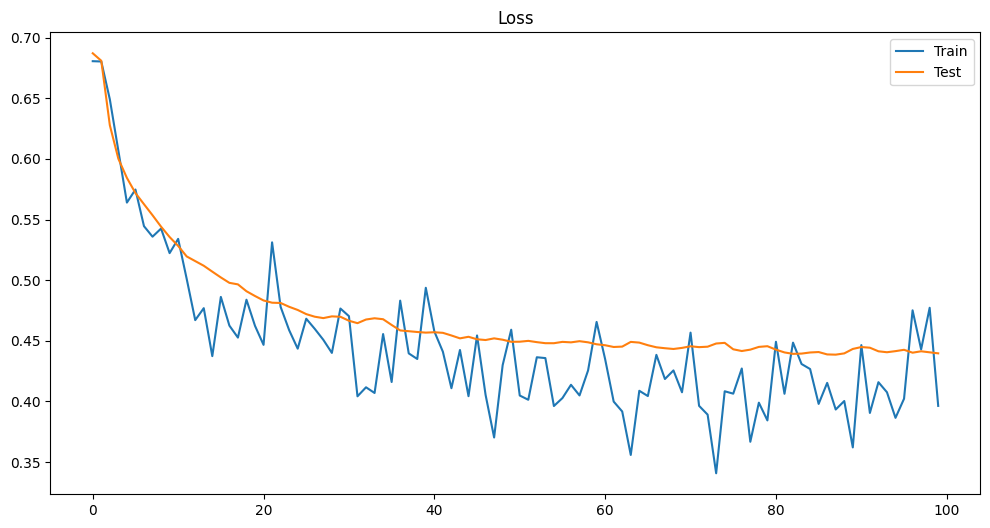

In [482]:
plt.figure(figsize=(12, 6))
plt.title("Loss")
plt.plot(range(epochs), train_loss_values, label="Train")
plt.plot(range(epochs), test_loss_values, label="Test")
plt.legend();